# Проект по теме "Численные методы"
# "Сервис по продаже автомобилей с пробегом"

## Описание проекта
Компания по продаже б/у автомобилей разрабатывает новую функцию своего приложения. В нём можно автоматически определить рыночную стоимость своего автомобиля.  
  
**Цель:** Необходимо построить модель для определения стоимости автомобилей на основании технических характеристик, комплектаций других данных.  

Метрики оптимизации:  
- качество предсказания;  
- скорость предсказания;  
- время обучения.  
  
  
**Задачи:**  
**1)** Загрузить и подготовить данные.  
**2)** Обучить разные модели. Для каждой попробовать различные гиперпараметеры.  
**3)** Проанализировать скорость работы и качество моделей.  

## Описание данных
Данные находятся в файле /datasets/autos.csv.  
  
- **Признаки**  
    - `DateCrawled` — дата скачивания анкеты из базы  
    - `VehicleType` — тип автомобильного кузова  
    - `RegistrationYear` — год регистрации автомобиля  
    - `Gearbox` — тип коробки передач  
    - `Power` — мощность (л. с.)  
    - `Model` — модель автомобиля  
    - `Kilometer` — пробег (км)  
    - `RegistrationMonth` — месяц регистрации автомобиля  
    - `FuelType` — тип топлива  
    - `Brand` — марка автомобиля  
    - `NotRepaired` — была машина в ремонте или нет  
    - `DateCreated` — дата создания анкеты  
    - `NumberOfPictures` — количество фотографий автомобиля  
    - `PostalCode` — почтовый индекс владельца анкеты (пользователя)  
    - `LastSeen` — дата последней активности пользователя  
    
- **Целевой признак**  
    - `Price` — цена (евро)  

**План выполнения работы:**  
- 1. Подготовка Данных  
    - 1.1 Изучение данных  
    - 1.2 Предобработка данных  
    - 1.3 Кодирование категориальных признаков  
    - 1.4 Подготовка выборок  
- 2. Обучение моделей  
    - 2.1 Линейная регрессия  
    - 2.2 Lasso/Ridge  
    - 2.3 LightGBM  
- 3. Анализ моделей  

# 1. Подготовка данных

## 1.1 Изучение данных

Подключаем библиотеки:
- `pandas` - для работы с таблицами  
- `seaborn` - для визуализации данных
- `display` - для вывода табличных данных
- `sklearn` - инструменты машинного обучения (модели регрессии, метрики для исследования качества моделей, разделение данных, предобработка данных)

In [1]:
import pandas as pd
import numpy as np
import re
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from numpy.random import RandomState
from scipy import stats

from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
import lightgbm
import catboost
%matplotlib inline

Загрузим данные из файлов, выведем первые 10 строк таблиц для первого взгляда на данные.  
Также с помощью метода info() изучим структуры таблиц: типы данных, количество строк, столбцов, пропущенных данных.

In [2]:
file_path = "/datasets/autos.csv"
data = pd.read_csv(file_path)
display(data.head(10))
print(data.info())
print('Количество дубликатов:', sum(data.duplicated()))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


- Признаки `NumberOfPictures`, `PostalCode` не несут полезной информации, удалим их. 
- Также `DateCrawled` повторяет дату в признаке `DateCreated`.
- Признак `Brand` скорее всего будет лишним при наличии конкретной модели автомобиля в признаке `Model`. 
- `RegistrationMonth` распределён равномерно и по смыслу вряд ли влияет на цену автомобиля.
- Избавимся от дублированний и неинформативных признаков.

In [4]:
data = data.drop(['NumberOfPictures', 'PostalCode', 'DateCrawled', 'RegistrationMonth'], axis=1)

In [5]:
numerical_features = ['DateCreated', 'Price', 'RegistrationYear', 'Power', 'Kilometer', 'LastSeen']
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired', 'Brand']

- Построим распределения данных в числовых признаках и на их зависимости от целевого признака `price`

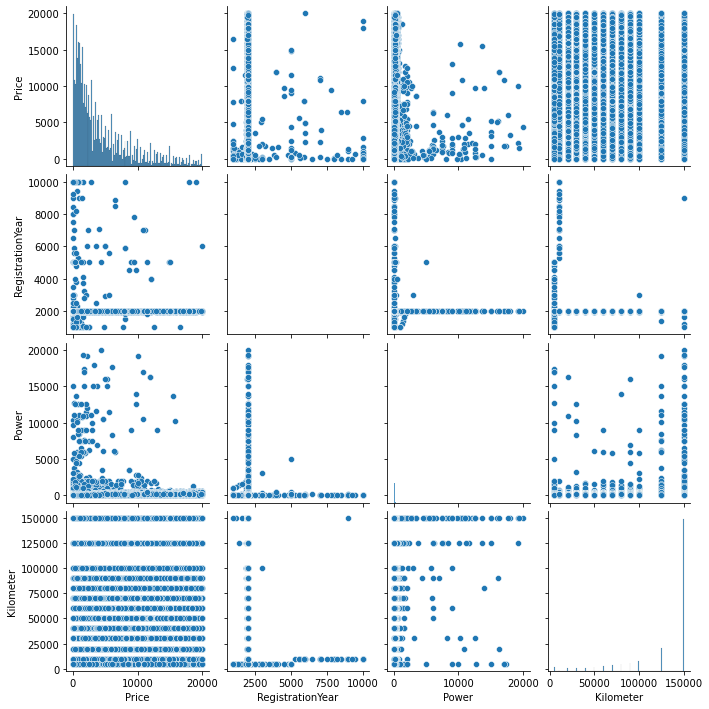

In [6]:
sns.pairplot(data)

## 1.2 Предобработка данных

- Отберём признаки, необходимые для построения модели
- Обработаем пропуски и выбросы

In [7]:
# для начала удалим дубликаты
data = data.drop_duplicates()

- Признак `Price`

In [8]:
f"Количество объявлений с нулевой ценой: {len(data.loc[data['Price'] == 0])}"

'Количество объявлений с нулевой ценой: 10771'

Данные о нулевой цене явно ошибочны (или продавцы не указывали цену в объявлении). На данный момент нет возможности восстановить целевой признак в этих объектах. Удалим их, чтобы не портить модель.

In [9]:
data = data.loc[data['Price'] != 0]

<AxesSubplot:xlabel='Price', ylabel='Count'>

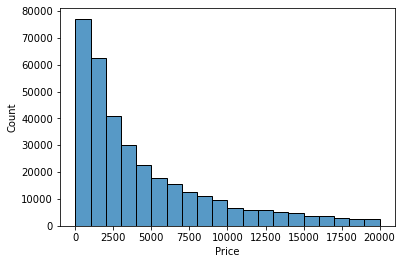

In [10]:
sns.histplot(data['Price'], bins=20)

- Признак `Model`

In [11]:
f"Количество объявлений с незаполненной моделью: {len(data.loc[data['Model'].isna()])}"

'Количество объявлений с незаполненной моделью: 17520'

Признак `Model` является одним из основных для предсказания цены. Пропущено 5% данных в этом признаке. Нет возможности восстановить корректно эти данные, удалим пропуски.

In [12]:
data = data.loc[~data['Model'].isna()]

- Признак `Power`

In [13]:
f"Количество автомобилей с мощностью > 1000 л.с.: {len(data.loc[(data['Power'] > 1000) | (data['Power'] <= 0)])}"

'Количество автомобилей с мощностью > 1000 л.с.: 31583'

Мощность > 1000 л.с. неправдоподобна. Заполним все непавдоподобные значения медианными среди автомобилей той же модели.

In [14]:
data.loc[(data['Power'] > 1000) | (data['Power'] <= 0), 'Power'] = None
data['Power'] = data['Power'].fillna(data.groupby('Model')['Power'].transform('median'))
data = data.loc[~data['Power'].isna()]
data['Power'] = data['Power'].astype('int64')

<AxesSubplot:xlabel='Power', ylabel='Count'>

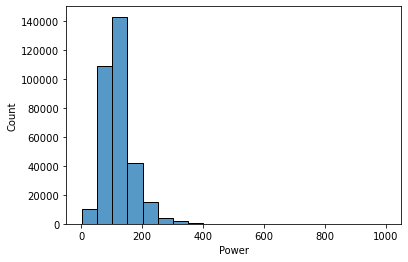

In [15]:
sns.histplot(data['Power'], bins=20)

<AxesSubplot:xlabel='Power', ylabel='Price'>

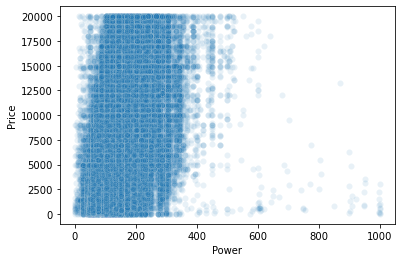

In [16]:
sns.scatterplot(x='Power', y='Price', data=data, alpha = 0.1)

- Признаки `DateCreated` и `LastSeen`

In [17]:
f"Минимальная дата рагистрации объявления: {min(data['DateCreated'])}"

'Минимальная дата рагистрации объявления: 2014-03-10 00:00:00'

Признаки `DateCreated` и `LastSeen` преобразуем в количество дней с момента `2014-03-01`.

In [18]:
base_date = pd.Timestamp('2014-03-01 00:00:00')
data['DateCreated'] = data['DateCreated'].map(lambda date : (pd.Timestamp(date) - base_date).days)

In [19]:
data['LastSeen'] = data['LastSeen'].map(lambda date : (pd.Timestamp(date) - base_date).days)

- Признак `RegistrationYear`

In [20]:
f"Количество объявлений с неправильным годом регистрации: {len(data.loc[data['RegistrationYear'] > 2020])}"

'Количество объявлений с неправильным годом регистрации: 58'

In [21]:
data.loc[data['RegistrationYear'] > 2020].head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated,LastSeen
12946,49,NaN,5000,NaN,101,golf,5000,NaN,volkswagen,NaN,759,767
17271,700,NaN,9999,NaN,116,other,10000,NaN,opel,NaN,753,766
18259,300,NaN,2200,NaN,58,twingo,5000,NaN,renault,NaN,746,768
26382,150,NaN,3000,NaN,95,a_klasse,5000,NaN,mercedes_benz,NaN,737,738
26560,800,NaN,2066,NaN,125,zafira,5000,gasoline,opel,NaN,754,759
28390,799,NaN,9999,NaN,150,3er,10000,petrol,bmw,NaN,766,768
28965,18000,NaN,9999,NaN,95,a_klasse,10000,petrol,mercedes_benz,NaN,765,768
29426,7999,NaN,9999,NaN,44,kaefer,10000,NaN,volkswagen,NaN,753,767
40954,59,NaN,8000,NaN,116,other,10000,NaN,chevrolet,NaN,737,768
45662,999,NaN,9000,NaN,69,fiesta,10000,NaN,ford,yes,753,766


Цену с неправильным годом регистрации также будет сложно предсказать, такие объявления могут внести ошибки в модель. Таких объектов мало, и данные по многим другим признакам также пропущены. Удалим эти объявления.

In [22]:
data = data.loc[data['RegistrationYear'] <= 2020]

- Признаки `VehicleType`, `Gearbox`, `FuelType`

Данные параметры c большой вероятностью одинаковы в одинаковых моделях автомобилей. Заполним пропуски в данных признаках наиболее частым значением той же модели.

In [23]:
data['VehicleType'] = data['VehicleType'].fillna(data
                                                  .groupby('Model')['VehicleType']
                                                  .transform(lambda x: x.value_counts().idxmax())
                                                 )

In [24]:
data['Gearbox'] = data['Gearbox'].fillna(data
                                         .groupby('Model')['VehicleType']
                                         .transform(lambda x: x.value_counts().idxmax())
                                        )

In [25]:
data['FuelType'] = data['FuelType'].fillna(data
                                           .groupby('Model')['VehicleType']
                                           .transform(lambda x: x.value_counts().idxmax())
                                          )

- Признак `NotRepaired`

In [26]:
data['NotRepaired'] = data['NotRepaired'].fillna('unknown')

- Посмотрим на получившиеся данные после обработки пропусков и выбросов

In [27]:
data.head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated,LastSeen
0,480,sedan,1993,manual,101,golf,150000,petrol,volkswagen,unknown,754,768
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown,744,766
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,747,747
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,761,767
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,765,767
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no,762,766
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,unknown,765,765
9,999,small,1998,manual,101,golf,150000,sedan,volkswagen,unknown,747,761
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no,756,767
11,2799,wagon,2005,manual,140,passat,150000,gasoline,volkswagen,yes,768,768


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325909 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             325909 non-null  int64 
 1   VehicleType       325909 non-null  object
 2   RegistrationYear  325909 non-null  int64 
 3   Gearbox           325909 non-null  object
 4   Power             325909 non-null  int64 
 5   Model             325909 non-null  object
 6   Kilometer         325909 non-null  int64 
 7   FuelType          325909 non-null  object
 8   Brand             325909 non-null  object
 9   NotRepaired       325909 non-null  object
 10  DateCreated       325909 non-null  int64 
 11  LastSeen          325909 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 32.3+ MB


## 1.3 Кодирование категориальных признаков

- В признаке `Model` много категорий, попробуем совместить его с признаком `Brand` и закодировать значением: **Model.size() / Brand.size()**

In [29]:
data['brand_model'] = data['Brand'].astype(str) + ' ' + data['Model'].astype(str)
data['model_code'] = data['brand_model'].map(data.groupby('brand_model').size()) / \
                     data['Brand'].map(data.groupby('Brand').size())
data_coded = data.drop(['brand_model', 'Brand', 'Model'], axis=1)

- Признаки `VehicleType`, `Gearbox`, `FuelType`, `NotRepaired` закодируем one-hot encoding.

In [30]:
def get_dummies_func(data, column, prefix):
    df = pd.get_dummies(data[column], prefix=prefix, drop_first=True)
    data = data.drop(column, axis=1)
    return data.join(df)

In [31]:
data_coded = get_dummies_func(data_coded, 'VehicleType', 'VType')

In [32]:
data_coded = get_dummies_func(data_coded, 'Gearbox', 'Gear')

In [33]:
data_coded = get_dummies_func(data_coded, 'FuelType', 'Fuel')

In [34]:
data_coded = get_dummies_func(data_coded, 'NotRepaired', 'Repair')

In [35]:
data_coded.head(10)

,Price,RegistrationYear,Power,Kilometer,DateCreated,LastSeen,model_code,VType_convertible,VType_coupe,VType_other,...,Fuel_hybrid,Fuel_lpg,Fuel_other,Fuel_petrol,Fuel_sedan,Fuel_small,Fuel_suv,Fuel_wagon,Repair_unknown,Repair_yes
0,480,1993,101,150000,754,768,0.396043,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,9800,2004,163,125000,744,766,0.373817,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,747,747,0.396043,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,3600,2008,69,90000,761,767,0.388051,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,765,767,0.562788,0,0,0,...,0,0,0,1,0,0,0,0,0,1
6,2200,2004,109,150000,762,766,0.478545,1,0,0,...,0,0,0,1,0,0,0,0,0,0
8,14500,2014,125,30000,765,765,0.028982,0,0,0,...,0,0,0,1,0,0,0,0,1,0
9,999,1998,101,150000,747,761,0.396043,0,0,0,...,0,0,0,0,1,0,0,0,1,0
10,2000,2004,105,150000,756,767,0.249660,0,0,0,...,0,0,0,1,0,0,0,0,0,0
11,2799,2005,140,150000,768,768,0.137974,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## 1.4 Подготовка выборок

- Выделим признаки, целевой признак. Разделим выборку на обучающую и тестовую в соотношении 1:4.

In [36]:
X = data_coded.drop('Price', axis=1)
y = data_coded['Price']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
f"Размер обучающей выборки: {X_train.shape}"

'Размер обучающей выборки: (260727, 36)'

In [39]:
f"Размер тестовой  выборки: {X_test.shape}"

'Размер тестовой  выборки: (65182, 36)'

- Проведём масштабирование признаков к стандартному нормальному распределению с помощью метода `StandardScaler` библиотеки `sklearn`

In [40]:
ss = StandardScaler()
ss.fit(X_train)
columns = X_train.columns
X_train = pd.DataFrame(ss.transform(X_train), columns = columns)
X_test = pd.DataFrame(ss.transform(X_test), columns = columns)

In [41]:
X_train.head(10)

,RegistrationYear,Power,Kilometer,DateCreated,LastSeen,model_code,VType_convertible,VType_coupe,VType_other,VType_sedan,...,Fuel_hybrid,Fuel_lpg,Fuel_other,Fuel_petrol,Fuel_sedan,Fuel_small,Fuel_suv,Fuel_wagon,Repair_unknown,Repair_yes
0,-0.019555,-0.340781,0.579140,0.446150,0.702209,-0.913564,-0.250460,-0.221351,-0.090067,-0.662243,...,-0.025768,-0.12302,-0.018991,-1.277907,-0.183497,-0.143575,-0.035975,-0.10216,-0.466591,-0.329923
1,-0.685446,-1.112035,-1.581784,1.403893,0.919999,-0.366058,-0.250460,-0.221351,-0.090067,-0.662243,...,-0.025768,-0.12302,-0.018991,0.782529,-0.183497,-0.143575,-0.035975,-0.10216,-0.466591,-0.329923
2,-0.400064,-0.321970,0.579140,0.233318,-0.495635,-1.001901,-0.250460,-0.221351,-0.090067,-0.662243,...,-0.025768,-0.12302,-0.018991,-1.277907,-0.183497,-0.143575,-0.035975,-0.10216,2.143203,-0.329923
3,0.075572,0.580962,-3.337534,0.339734,0.266629,-0.929287,-0.250460,-0.221351,-0.090067,-0.662243,...,-0.025768,-0.12302,-0.018991,-1.277907,-0.183497,-0.143575,-0.035975,-0.10216,-0.466591,3.031012
4,-0.019555,-0.058615,0.579140,-0.724425,0.375524,0.017244,-0.250460,-0.221351,-0.090067,-0.662243,...,-0.025768,-0.12302,-0.018991,0.782529,-0.183497,-0.143575,-0.035975,-0.10216,-0.466591,-0.329923
5,-0.304937,-0.848680,-0.096149,1.084646,0.811104,-0.263466,-0.250460,-0.221351,-0.090067,-0.662243,...,-0.025768,-0.12302,-0.018991,0.782529,-0.183497,-0.143575,-0.035975,-0.10216,2.143203,-0.329923
6,-0.114683,-0.961547,0.579140,0.658982,0.919999,0.883360,-0.250460,-0.221351,-0.090067,-0.662243,...,-0.025768,-0.12302,-0.018991,-1.277907,-0.183497,-0.143575,-0.035975,-0.10216,-0.466591,-0.329923
7,0.170699,-1.224902,0.579140,-0.830840,-1.475689,-0.366058,-0.250460,-0.221351,-0.090067,-0.662243,...,-0.025768,-0.12302,-0.018991,0.782529,-0.183497,-0.143575,-0.035975,-0.10216,2.143203,-0.329923
8,-0.495191,-0.340781,0.579140,0.552566,0.811104,0.883360,3.992659,-0.221351,-0.090067,-0.662243,...,-0.025768,-0.12302,-0.018991,0.782529,-0.183497,-0.143575,-0.035975,-0.10216,-0.466591,-0.329923
9,-0.495191,-1.300146,0.579140,-0.085929,-1.040110,0.511772,-0.250460,-0.221351,-0.090067,-0.662243,...,-0.025768,-0.12302,-0.018991,0.782529,-0.183497,-0.143575,-0.035975,-0.10216,-0.466591,-0.329923


### Вывод

- Данные были успешно загружены и проанализированы. Типы данных соответствуют описанию, дубликаты удалены.
- Отобраны признаки, необходимые для построения моделей.
- Пропущенные значения, выбросы, а также неправдоподобные значения в признаках по возможности заполнены на основе имеющейся инфрмации. Остальные объекты удалены (около 8% данных).
- Категориальные признаки с небольшой ординальностью преобразованы с помощью one-hot encoding. Признак `Model` закодирован по формуле **Model.size() / Brand.size()**
- Данные разделены на тестовую и обучающую выборки в соотношении 1:4, признаки масштабированы к стандартному нормальному распределению.

# 2. Обучение моделей

- Для начала создадим константную base-line модель. Она всегда будет предсказывать среднее значение `Price`. (среднее значение на практике дало меньшее значение RMSE, чем медианное). Рассчитаем RMSE для base-line модели.

In [42]:
preds_base = pd.Series(data=y.mean(), index=y.index, dtype='int64')
rmse_base = mean_squared_error(y, preds_base) ** 0.5
f"RMSE для константной модели: {round(rmse_base, 2)}"

'RMSE для константной модели: 4530.45'

## 2.1 Линейная регрессия

- Сначала обучим линейную модель. Посчитаем скорость обучения, скорость предсказания и RMSE модели. Обучение будем проводить с использованием кросс-валидации на 5 фолдов.

In [43]:
%%time
lm = LinearRegression()
mse = cross_val_score(lm, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

Wall time: 1.07 s


In [44]:
f"RMSE для линейной модели на валидационной выборке: {round((-mse.mean()) ** 0.5, 2)}"

'RMSE для линейной модели на валидационной выборке: 2985.85'

In [45]:
%%time
lm = LinearRegression()
lm.fit(X_train, y_train)

Wall time: 219 ms


LinearRegression()

In [46]:
%%time
preds_lm = lm.predict(X_test)

Wall time: 8.01 ms


In [47]:
mse_lm = mean_squared_error(y_test, preds_lm)
f"RMSE для линейной модели на тестовой выборке: {round((mse_lm) ** 0.5, 2)}"

'RMSE для линейной модели на тестовой выборке: 3005.06'

## 2.2 Lasso/Ridge

- Попробуем обучить линейные модели с регуляризацией L1 и L2.

**1) Lasso** (L1 регуляризация)

In [48]:
%%time
alphas = np.arange(1, 40, 4)
for alpha in alphas :
    lasso = Lasso(alpha = alpha)
    mse = cross_val_score(lasso, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print("RMSE для Lasso alpha={:.2f} модели на валидационной выборке: {:.2f}".format(alpha, (-mse.mean()) ** 0.5))

RMSE для Lasso alpha=1.00 модели на валидационной выборке: 2985.86
RMSE для Lasso alpha=5.00 модели на валидационной выборке: 2986.05
RMSE для Lasso alpha=9.00 модели на валидационной выборке: 2986.32
RMSE для Lasso alpha=13.00 модели на валидационной выборке: 2986.79
RMSE для Lasso alpha=17.00 модели на валидационной выборке: 2987.44
RMSE для Lasso alpha=21.00 модели на валидационной выборке: 2988.26
RMSE для Lasso alpha=25.00 модели на валидационной выборке: 2989.23
RMSE для Lasso alpha=29.00 модели на валидационной выборке: 2990.34
RMSE для Lasso alpha=33.00 модели на валидационной выборке: 2991.59
RMSE для Lasso alpha=37.00 модели на валидационной выборке: 2992.93
Wall time: 16.9 s


In [49]:
%%time
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

Wall time: 3.83 s


Lasso(alpha=0.1)

In [50]:
%%time
preds_ls = lasso.predict(X_test)

Wall time: 6.01 ms


In [51]:
mse_ls = mean_squared_error(y_test, preds_ls)
f"RMSE для Lasso модели на тестовой выборке: {round((mse_ls) ** 0.5, 2)}"

'RMSE для Lasso модели на тестовой выборке: 3005.06'

- Lasso не дало выигрыш в метрике, скорость обучения и предсказания немного выше, чем у Линейной модели без регуляризации.

**2) Ridge** (L2 регуляризация)

In [52]:
%%time
alphas = np.arange(1, 40, 4)
for alpha in alphas :
    ridge = Ridge(alpha = alpha)
    mse = cross_val_score(ridge, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print("RMSE для Ridge alpha={:.2f} модели на валидационной выборке: {:.2f}".format(alpha, (-mse.mean()) ** 0.5))

RMSE для Ridge alpha=1.00 модели на валидационной выборке: 2985.85
RMSE для Ridge alpha=5.00 модели на валидационной выборке: 2985.85
RMSE для Ridge alpha=9.00 модели на валидационной выборке: 2985.85
RMSE для Ridge alpha=13.00 модели на валидационной выборке: 2985.85
RMSE для Ridge alpha=17.00 модели на валидационной выборке: 2985.85
RMSE для Ridge alpha=21.00 модели на валидационной выборке: 2985.85
RMSE для Ridge alpha=25.00 модели на валидационной выборке: 2985.85
RMSE для Ridge alpha=29.00 модели на валидационной выборке: 2985.85
RMSE для Ridge alpha=33.00 модели на валидационной выборке: 2985.85
RMSE для Ridge alpha=37.00 модели на валидационной выборке: 2985.85
Wall time: 6.17 s


In [53]:
%%time
ridge = Ridge(alpha=0.5)
ridge.fit(X_train, y_train)

Wall time: 81 ms


Ridge(alpha=0.5)

In [54]:
%%time
preds_rg = ridge.predict(X_test)

Wall time: 7 ms


In [55]:
mse_rg = mean_squared_error(y_test, preds_rg)
f"RMSE для Ridge модели на тестовой выборке: {round((mse_rg) ** 0.5, 2)}"

'RMSE для Ridge модели на тестовой выборке: 3005.06'

- Ridge не дал выигрыш в метрике, но скорость обучения выше, чем у Линейной модели без регуляризации:
    - Ridge fit time: 80 ms
    - LinearRegression fit time: 229 ms

## 2.3 LightGBM

- Попробуем обучить модель с градиентным бустингом: LightGBM.  
- Подбор параметров проведём с помощью GridSearch библиотеки sklearn.

In [56]:
numerical_features = ['DateCreated', 'Price', 'RegistrationYear', 'Power', 'Kilometer', 'LastSeen']
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired', 'Brand']

In [57]:
data = data.drop(['brand_model', 'model_code'], axis=1)

In [58]:
X = data_coded.drop('Price', axis=1)
y = data_coded['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
f"Размер обучающей выборки: {X_train.shape}"

'Размер обучающей выборки: (260727, 36)'

In [60]:
f"Размер обучающей выборки: {X_test.shape}"

'Размер обучающей выборки: (65182, 36)'

In [62]:
categorical_features = [col for col in list(data_coded.columns) if col not in numerical_features]

In [63]:
%%time
train_data = lightgbm.Dataset(X_train, label=y_train, 
                              free_raw_data=False,
                              categorical_feature=categorical_features)
test_data = lightgbm.Dataset(X_test, label=y_test)

param_grid = {'learning_rate': [0.1, 0.3, 0.5, 0.7],
              'max_depth': [15, 20, 30, 35],
             }

lgbm = lightgbm.LGBMRegressor(n_jobs = 8)

# инициализируем GridSearchCV
grid_search = GridSearchCV(estimator = lgbm, 
                           param_grid = param_grid, 
                           cv = 3,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_mean_squared_error',
                          )
grid_search.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Wall time: 35.2 s


GridSearchCV(cv=3, estimator=LGBMRegressor(n_jobs=8), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 0.5, 0.7],
                         'max_depth': [15, 20, 30, 35]},
             scoring='neg_mean_squared_error')

In [64]:
print(grid_search.best_params_)

{'learning_rate': 0.5, 'max_depth': 15}


In [65]:
print('RMSE для LightGBM модели на валидационной выборке: {:.2f}'.format((-grid_search.best_score_) ** 0.5))

RMSE для LightGBM модели на валидационной выборке: 1654.88


In [66]:
%%time
preds_lgbm = grid_search.best_estimator_.predict(X_test)

Wall time: 101 ms


In [67]:
mse_lgbm = mean_squared_error(y_test, preds_lgbm)
f"RMSE для LightGBM модели на тестовой выборке: {round((mse_lgbm) ** 0.5, 2)}"

'RMSE для LightGBM модели на тестовой выборке: 1638.9'

### Вывод

- Проведено обучение моделей линейной регрессии без/с регуляризацией, а также модели градиентного бустинга LightGBM.
- Измерены время обучения/предсказания моделей, а так же качество предсказаний по метрике RMSE.

# 3. Анализ моделей

- Все обученные модели смогли улучшить RMSE базовой модели.
- Линейная модель без регуляризации для данной задачи показала качество предсказаний не хуже, чем Lasso и Ridge. Метрика **RMSE** для LightGBM в два раза ниже:
    - Base-line: 4530.45
    - LinearModel: 3005.1
    - Lasso 3005.1
    - Ridge 3005.1
    - **LightGBM: 1638.9** 
- **По времени обучения** Ridge модель оказалась быстрее всех. Lasso значительно уступает линейной модели без регуляризации. Обучение LightGBM оказалось не намного дольше (31.9 с на 16 моделей в GridSerch):
    - LinearModel: 229 ms
    - Lasso 3.56 s
    - Ridge 80 ms
    - **LightGBM: +- 2c** на модель
- **По времени предсказания** линейные модели ведут себя одинаково. LightGBM более тяжелая модель, время предсказания выше на порядок.
    - LinearModels: +- 8 ms
    - **LightGBM: 101 ms**